<a href="https://colab.research.google.com/github/davidabelin/doubledigits/blob/main/arithmetic_double_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Handwritten Digit Classification

In [2]:
#@title IMPORTS
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sbn

import zipfile
import math
import random as rd
import numpy as np
import pandas as pd
import os, signal
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
#from tensorflow.keras.preprocessing.image import img_to_array, load_img
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, InputLayer, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

## Construct the Input Data

In [3]:
#Load
mnist = tf.keras.datasets.mnist
(imgs_train, ans_train), (imgs_test, ans_test) = mnist.load_data()

# Knobs
nrows = 2
ncols = 5

N = 10000 # num training examples
image_size = (28,56)

# Data
imgs_train.shape, imgs_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

Answer: 5 * 10 + 4 = 54


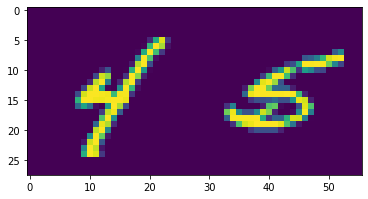

In [4]:
im = np.zeros(image_size)
left_index = rd.randint(0,len(ans_train)-1)   
right_index = rd.randint(0,len(ans_train)-1) 
for i in range(image_size[1]//2):
    im[:,i] = imgs_train[left_index,:,i]
    im[:,i+image_size[1]//2] = imgs_train[right_index,:,i]

maxswer = np.max([ans_train[left_index],ans_train[right_index]])
minswer = np.min([ans_train[left_index],ans_train[right_index]])
answer = maxswer*10 + minswer

print ("Answer:", maxswer,"* 10 +",minswer,"=",answer)
#print ("Answer:", ans_train[left_index],"<>",ans_train[right_index],"=",answer)
plt.imshow(im)

Multiply
[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          96.54545455 255.          23.18181818   0.
    0.           0.         123.18181818 255.          46.54545455]
 [  0.           0.          92.66666667 255.          21.25
    0.         121.25       255.          42.66666667   0.        ]
 [  0.           0.           0.          89.38461538 255.
  129.42307692 255.          39.38461538   0.           0.        ]
 [  0.           0.           0.           0.         161.5
  255.          45.67857143   0.           0.           0.        ]
 [  0.           0.           0.         117.         255.
  101.2        255.          17.           0.           0.        ]
 [  0.           0.         115.9375     255.          32.
    0.          82.         255.        

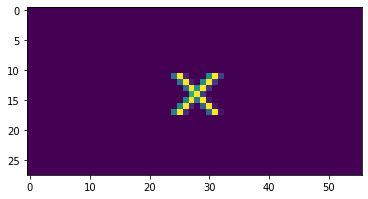

In [5]:
def getOperator(image, operation):
    if operation == 'Multiply':     #MULTIPLY
        for row in range(11,18):
            image[28-row,row+14] = 255
            image[row,row+14] = 255
            image[row,row+15] /= 2
            image[row,row+15] += 255/row
            image[row,row+13] /= 2
            image[row,row+13] += 50 + 512/row
            image[28-row,row+13] /= 2
            image[28-row,row+13] += 100 + 255/(28-row)
            image[28-row,row+15] /= 2
            image[28-row,row+15] += 512/(28-row)
    else:
        if operation == 'Divide':       #DIVIDE
            for row in range(8,21):
                image[28-row,row+14] = 255
                image[28-row,row+13] /= 2
                image[28-row,row+13] += 60 + 255/row
                image[28-row,row+15] /= 2
                image[28-row,row+15] += 512/(28-row)
        else:
            image[14,24:32] = 255  # MINUS SIGN (FOR BOTH ADD AND SUB)
            if (image[13,24:32] > 255-99).any():  
                image[13,24:32] /= 2
            image[13,24:32] += 99
            if (image[15,25:31] > 255-33).any():
                image[15,25:31] /= 2
            image[15,25:31] += 33
        
            if operation == 'Add': 
                image[10:18,28] = 255
                if (image[10:18,27] > 255-99).any():
                    image[10:18,27] /= 2
                image[10:18,27] += 99  # PLUS SIGN

    return image

op = rd.choice(['Add','Multiply','Subtract','Divide'])
image = getOperator(np.zeros((28,56)),op)
#(image[9:19,23:33] > 255).any()
print (op)
print(image[9:19,23:33])
plt.imshow(image)#[9:19,23:33])

Answer = 3 * 10 + 6 = 36


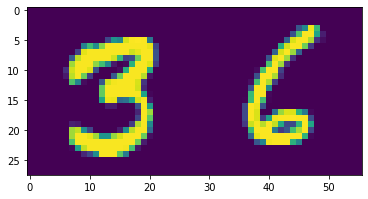

In [6]:
#from dd_convo
im = np.zeros((28,56))
tens_index = rd.randint(0,len(ans_train)-1)   
ones_index = rd.randint(0,len(ans_train)-1) 
for i in range(28):
    im[:,i] = imgs_train[tens_index,:,i]
    im[:,i+28] = imgs_train[ones_index,:,i]
answer = ans_train[tens_index]*10 + ans_train[ones_index]
print ("Answer =", ans_train[tens_index],"* 10 +",ans_train[ones_index],"=",answer)
plt.imshow(im)

In [7]:
def doubleDigits(images=imgs_train,answers=ans_train,ops=True):

    image = np.zeros(image_size)
    left_index = rd.randint(0, len(answers)-1)   
    right_index = rd.randint(0, len(answers)-1)
    for i in range(28):                 # PUT IN THE DIGITS
        image[:,i] = images[left_index,:,i]
        image[:,i+28] = images[right_index,:,i]
    if ops:                           # MAKE ARITHMETIC SET
        operation =  rd.choice(['Add','Multiply','Subtract','Divide']) # TRUE+*  FALSE-/
        if operation == 'Add':                       #ADD
                answer = answers[left_index] + answers[right_index] 
        else: 
            if operation == 'Multiply':                   #MULTIPLY
                    answer = answers[left_index] * answers[right_index]
            else:               #SUBTRACT AND DIVIDE
                maxswer = np.max([answers[left_index],answers[right_index]])
                minswer = np.min([answers[left_index],answers[right_index]])
                if operation == 'Subtract':       #SUBTRACT
                    answer = maxswer - minswer
                else:                               #DIVIDE        
                    if minswer == 0:
                        answer = 99
                    else:
                        answer = int(round(maxswer / minswer))
        image = getOperator(image, operation)

    else:                # DOUBLE DIGITS BY DEFAULT
        answer = answers[left_index]*10 + answers[right_index]   

    return image, answer              
    #returns image array, list of answers
print("Loaded function doubleDigits.")

def getDoubleDigits(images=imgs_train,answers=ans_train,how_many=1,ops=True):
    yy = []
    xx = []
    for i in range(how_many):
        dd, ans = doubleDigits(images,answers,ops)
        yy += [ans]
        xx.append(dd)
        if i%500 == 0:
            print("Loaded:",i,"of,",how_many,"examples...")
            clear_output(wait=True)
    print("Loaded:",how_many,"examples.")
    return xx, yy

print("Loaded function getDoubleDigits.")

Loaded function doubleDigits.
Loaded function getDoubleDigits.


Loaded: 1 examples.
~Random example~
Answer: 9


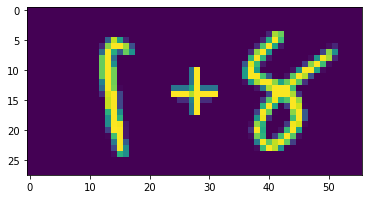

In [8]:
# AND FINALLY CALL FUNCTION gDD TO SHOW AN EXAMPLE OF A 
# CONSTRUCTED IMAGE AND ANSWER TO MAKE SURE IT LOOKS OK
x, y = getDoubleDigits(imgs_test,ans_test,ops=True)
print('~Random example~')
print('Answer:',y[0])
plt.imshow(x[0])

In [9]:
######### GENERATE DD TRAINING DATA FOR FIRST MODEL #################
xts, y_test = getDoubleDigits(imgs_test,ans_test,N//10,ops=True)
x_test = np.array(xts) / 255.
print("Made",N//10,"new double-digit images to test on.")

xtn, y_train = getDoubleDigits(imgs_train,ans_train,N,ops=True)
x_train = np.array(xtn) / 255.
print("Made",N,"new double-digit images to train on.")

######################## Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

####################### TF Datasets for input
train_ds = tf.data.Dataset.from_tensor_slices( (x_train, y_train) )
test_ds = tf.data.Dataset.from_tensor_slices( (x_test, y_test) )

Loaded: 10000 examples.
Made 10000 new double-digit images to train on.


# Build Convolutional NN

In [10]:
###################### Build CNN as first model
input_layer = layers.Input(shape=(image_size[0], image_size[1], 1))

x = layers.Conv2D(10, 2, padding='same', activation='relu')(input_layer)
#x = layers.Conv2D(100, 2, padding='same', activation='relu')(x) 
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(10, 2, padding='same', activation='relu')(x) 
#x = layers.MaxPooling2D((4,8))(x)
x = layers.Flatten()(x)
output_layer = layers.Dense(100, activation='softmax')(x)
######################### 100 or else dict(list(set(y_train))!

####################### Build
model = Model(input_layer, output_layer)

####################### Compile
model.compile(loss="sparse_categorical_crossentropy",
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(lr=0.0025), #0.0075
              metrics=['acc'])
    
####################### Layer-outputs model
layer_outputs = [layer.output for layer in model.layers[1:]]
output_model = Model(input_layer, layer_outputs)

####################### History containers
answers, guesses = [],[]
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 56, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 56, 10)        50        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 28, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 28, 10)        410       
_________________________________________________________________
flatten (Flatten)            (None, 3920)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               392100    
Total params: 392,560
Trainable params: 392,560
Non-trainable params: 0
_______________________________________________________

### Training / Loading and reloading

In [11]:
############################# Train the CNN first:
mhistory = model.fit(train_ds.shuffle(N+1).batch(N//10),
                     validation_data=test_ds.batch(N//200),  
                     epochs=1,  
                     verbose=1)

10/10 [==============================] - 5s 57ms/step - loss: 3.8932 - acc: 0.0801 - val_loss: 3.0282 - val_acc: 0.1170


In [12]:
##################### Put in a small NN at the end
for layer in model.layers:
    layer.trainable = False
    if "conv2d" in layer.name: out_layer = layer.name

x = model.get_layer(out_layer).output
x = layers.Flatten()(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.2)(x)
new_output_layer = layers.Dense(100, activation='softmax')(x)
new_model = Model(input_layer, new_output_layer)
new_model.compile(loss="sparse_categorical_crossentropy",
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(lr=0.0025), #0.0075
              metrics=['acc'])

####################### Layer-outputs for new model
new_layer_outputs = [layer.output for layer in new_model.layers[1:]]
new_output_model = Model(input_layer, new_layer_outputs)

new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 56, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 56, 10)        50        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 28, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 28, 10)        410       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               392100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0   

In [13]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
############################# Train new_model
new_history = new_model.fit(train_ds.shuffle(N+1).batch(N//100),
                            validation_data=test_ds.batch(N//200),  
                            epochs=20,  
                            verbose=1)

In [15]:
#plotLearningCurves(new_history)

### Visualizing Intermediate Representations


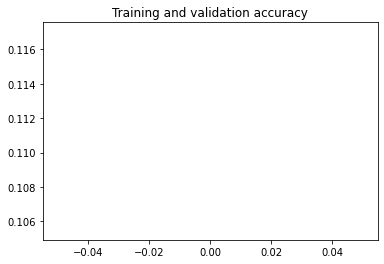

In [46]:
#@title Display learning curves 
def plotLearningCurves(history=mhistory):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')

    #plt.figure()

    #plt.plot(epochs, loss)
    #plt.plot(epochs, val_loss)
    #plt.title('Training and validation loss')

plotLearningCurves()

In [17]:
#@title Deprecated Functions NO_GUESSING() and NO_GET_RESULTS()
def no_guessing(N=1,model=model,X=False):
    answers, guesses = [],[]
    for count in range(N):
        if X:
            take1_ds = testX_ds.shuffle(10001).take(1)    
        else:
            take1_ds = test_ds.shuffle(10001).take(1)
        for img, ans in take1_ds:
            ans = ans.numpy()
            img = img.numpy()                  # 28x56x1
        img = img.reshape((1,) + img.shape)    # 1x28x56x1
        guess_set = model.predict(img)
        #guess = tf.random.categorical( guess_set, num_samples=1 ).numpy().squeeze()
        guess = np.argmax(guess_set)
        
        answers += [ans]
        guesses += [guess]
        #pG += [guess_set[guess]]
        #pA += [guess_set[answer]]
        #print("Answer",answer,"\tGuess",guess)#, "\tp(A)",pA,"\tp(G)",pG)
       
        if count%20 == 0:
            print ('Processing...',count,"...")
            clear_output(wait=True)

    return answers, guesses#, pA, pG

def no_get_results(N=1,m=model,X=False):
    no_results = pd.DataFrame(columns=['Answer','Guess'])#,'P(A)','P(G)'])
    no_results['Answer'], no_results['Guess'] = no_guessing(N, m, X) #, results['P(A)'], results['P(G)'] 
    return no_results

In [18]:
#@title Functions GUESSING() and GET_RESULTS()
def guessing(n=1,model=model,return_image=False):
    answers, guesses, pA, pG = [],[],[],[]
    for count in range(n):
        take1_ds = test_ds.shuffle(N+1).take(1)
        for img, ans in take1_ds:
            ans = ans.numpy()
            img = img.numpy()                  # eg. 28x56x1
        img = img.reshape((1,) + img.shape)    # eg. 1x50x50x1
        guess_set = model.predict(img).flatten()
        #guess = tf.random.categorical( guess_set, num_samples=1 ).numpy().squeeze()
        guess = np.argmax(guess_set)
        
        answers += [ans]
        guesses += [guess]
        pG += [guess_set[guess]]
        pA += [guess_set[ans]]

        print("Answer",ans,"\tGuess",guess, "\tp(A)",round(pA[count],2),"\tp(G)",round(pG[count],2))
        if count%10 == 0:
            print ('Processing...',count,"...")
            clear_output(wait=True)

    if return_image:
        return answers, guesses, pA, pG, img
    else:
        return answers, guesses, pA, pG

def get_results(n=1,m=model):
    results = pd.DataFrame(columns=['Answer','Guess','P(A)','P(G)'])
    results['Answer'], results['Guess'], results['P(A)'], results['P(G)'] = guessing(n, m) 
    return results

2 2
0.23746452 0.23746452


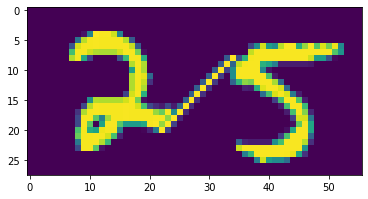

In [19]:
answers, guesses, pA, pG, img = guessing(1, return_image=True)
print (answers[0], guesses[0])
print (pA[0], pG[0])
plt.imshow(img[0,:,:,0])

Answer: 2 	Guess: 2


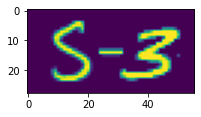

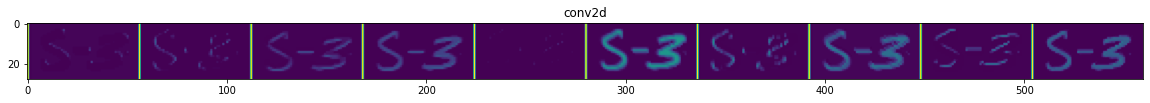

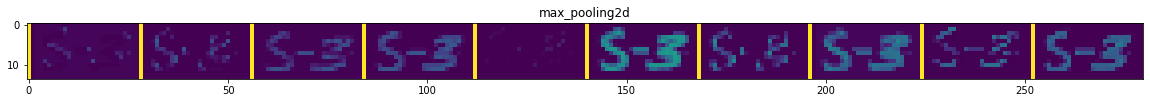

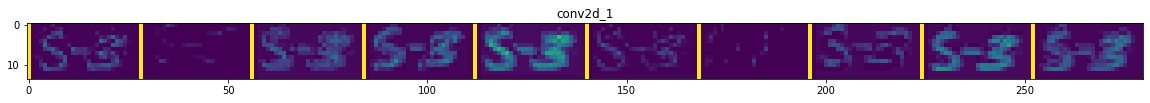

In [20]:
#@title Show layer output from first model...

# Take random image from the training set.
take1_ds = test_ds.shuffle(10001).take(1)
for img, ans in take1_ds:
    img = img.numpy()
    ans = ans.numpy()
img = img.reshape((1,) + img.shape)    # np shape (1, 28, 28, 1)
gue = model.predict(img)
print("Answer:",ans, "\tGuess:",np.argmax(gue))
plt.figure(figsize=(3,3))
plt.imshow(img[0,:,:,0])                 # np shape (28, 28)

layer_output_maps = output_model.predict( img )
layer_names = [layer.name for layer in model.layers[1:]]
for layer_name, layer_map in zip(layer_names, layer_output_maps):
    if len(layer_map.shape) == 4:# and not 'max_pooling' in layer_name:
        n_maps = layer_map.shape[-1]  # number of maps
        if n_maps > 10:
            n_maps = 10
        # Map has shape (1, rows, columns, n_features)
        rows = layer_map.shape[1]
        cols = layer_map.shape[2]
        image_grid = np.zeros((rows, cols * n_maps))
        
        for i in range(n_maps):
            x = layer_map[0, :, :, i]
            x *= 255.0
            image_grid[:, i * cols : (i + 1) * cols] = x
            image_grid[:,i*cols] = 255.
            image_grid[:,i*cols+1] = 0.
            
        scale = 2.           
        plt.figure(figsize=(scale * n_maps, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(image_grid, cmap='viridis')
 

Answer: 1 	Guess: 3


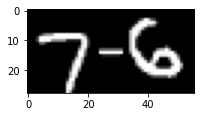

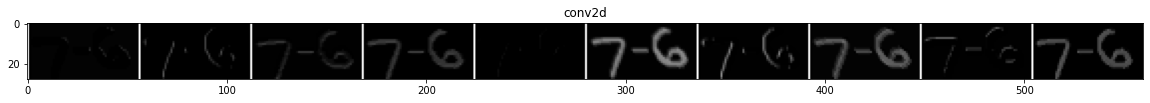

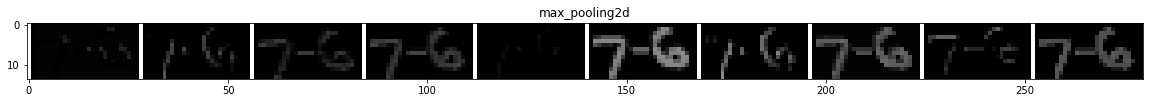

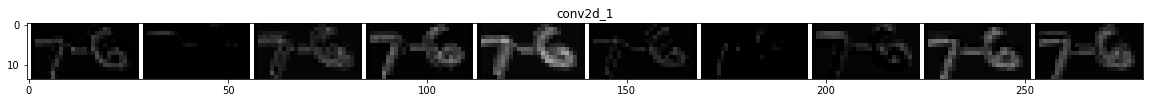

In [21]:
#@title Show layer output from "new model" with small NN

# Take random image from the training set.
take1_ds = test_ds.shuffle(10001).take(1)
for img, ans in take1_ds:
    img = img.numpy()
    ans = ans.numpy()
img = img.reshape((1,) + img.shape)    # np shape (1, 28, 28, 1)
gue = new_model.predict(img)
print("Answer:",ans, "\tGuess:",np.argmax(gue))
plt.figure(figsize=(3,3))
plt.imshow(img[0,:,:,0], cmap="binary_r")                 # np shape (28, 28)

layer_output_maps = new_output_model.predict( img )
layer_names = [layer.name for layer in new_model.layers[1:]]
for layer_name, layer_map in zip(layer_names, layer_output_maps):
    if len(layer_map.shape) == 4:# and not 'max_pooling' in layer_name:
        n_maps = layer_map.shape[-1]  # number of maps
        if n_maps > 10:
            n_maps = 10
        # Map has shape (1, rows, columns, n_features)
        rows = layer_map.shape[1]
        cols = layer_map.shape[2]
        image_grid = np.zeros((rows, cols * n_maps))
        
        for i in range(n_maps):
            x = layer_map[0, :, :, i]
            x *= 255.0
            image_grid[:, i * cols : (i + 1) * cols] = x
            image_grid[:,i*cols] = 255.
            image_grid[:,i*cols+1] = 0.
            
        scale = 2.           
        plt.figure(figsize=(scale * n_maps, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(image_grid, cmap='gray')
 

### examine results.

In [22]:
results = get_results(100,new_model)
results

Answer 32 	Guess 32 	p(A) 0.6 	p(G) 0.6
Answer 0 	Guess 56 	p(A) 0.32 	p(G) 0.37
Answer 0 	Guess 0 	p(A) 0.35 	p(G) 0.35
Answer 10 	Guess 8 	p(A) 0.15 	p(G) 0.23
Answer 1 	Guess 3 	p(A) 0.08 	p(G) 0.47
Answer 5 	Guess 5 	p(A) 0.57 	p(G) 0.57
Answer 1 	Guess 1 	p(A) 0.54 	p(G) 0.54
Answer 4 	Guess 3 	p(A) 0.05 	p(G) 0.19
Answer 99 	Guess 99 	p(A) 1.0 	p(G) 1.0


,Answer,Guess,P(A),P(G)
0,11,11,0.306097,0.306097
1,4,8,0.132430,0.342842
2,0,0,0.994769,0.994769
3,1,7,0.053244,0.429817
4,36,36,0.430734,0.430734
...,...,...,...,...
95,1,3,0.078260,0.468263
96,5,5,0.569855,0.569855
97,1,1,0.536471,0.536471
98,4,3,0.051520,0.194344


In [23]:
tv = results['Guess'] == results['Answer']
wrongs = results.loc[~tv]
wrongs.sort_values('Answer')

,Answer,Guess,P(A),P(G)
92,0,56,0.319385,0.372276
73,1,8,0.070460,0.291148
3,1,7,0.053244,0.429817
59,1,2,0.135047,0.562737
15,1,7,0.084644,0.324553
95,1,3,0.078260,0.468263
66,1,2,0.346565,0.382825
5,2,1,0.128626,0.333634
80,2,3,0.115928,0.294112
75,2,4,0.204286,0.250850


#Build modelX

In [24]:
######### GENERATE NEW TRAINING DATA  #################
######### usually no need to get more data! ###########
def get_new_data(n=N,ops=True):
    xts, y_testX = getDoubleDigits(images=imgs_test,
                                   answers=ans_test,
                                   how_many=n,
                                   ops=True)
    x_testX = np.array(xts) / 255.
    print("Made",n,"new images to test on.")

    xtn, y_trainX = getDoubleDigits(imgs_train,
                                    ans_train,
                                    n,
                                    ops=True)
    x_trainX = np.array(xtn) / 255.
    print("Made",n,"new images to train on.")

    print(len(set(y_trainX)),"unique labels:",set(y_trainX))

    ######################## Add a channels dimension
    x_trainX = x_trainX[..., tf.newaxis].astype("float32")
    x_testX = x_testX[..., tf.newaxis].astype("float32")

    ####################### TF Datasets for input
    trainX_ds = tf.data.Dataset.from_tensor_slices( (x_trainX, y_trainX) )
    testX_ds = tf.data.Dataset.from_tensor_slices( (x_testX, y_testX) )

    return x_trainX, y_trainX, x_testX, y_testX, trainX_ds, testX_ds

In [25]:
#x_trainX, y_trainX, x_testX, y_testX, trainX_ds, testX_ds = get_new_data(n=N,X=True)
#x_trainX, y_trainX, x_testX, y_testX, trainX_ds, testX_ds = x_train, y_train, x_test, y_test, train_ds, test_ds

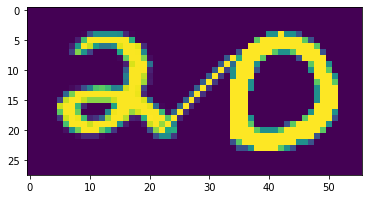

In [26]:
plt.imshow(rd.choice(x_train)[:,:,0])

In [27]:
###### ALTERNATIVE BUILD: NN MODEL ########### 

###### and optional CNN on top?
#x = layers.Conv2D(5, 2, padding='same', activation='relu')(input_layer)
#x = layers.Conv2D(10, 3, padding='same', activation='relu')(x) 

#x = layers.Dense(10, activation='relu')(input_layer)
#x = layers.Dropout(0.5)(x)


########################### This works ###########################
x = layers.Flatten()(input_layer)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(100, activation='relu')(x) 
x = layers.Dropout(0.1)(x)
output_layer = layers.Dense(100, activation='softmax')(x) 
modelX = Model(input_layer, output_layer)
########################### ^^^^^^^^^^ ###########################


####################### Compile
modelX.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(lr=0.0025), #0.0025),
              metrics=['acc'])
    
####################### Layer-outputs model
layer_outputsX = [layer.output for layer in modelX.layers[1:]]
output_modelX = Model(input_layer, layer_outputsX)

####################### History containers
answersX, guessesX = [],[]

####################### Summary
modelX.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 56, 1)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               156900    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1010

In [28]:
############################# Train modelX
historyX = modelX.fit(train_ds.shuffle(N+1).batch(N//100), 
                     epochs=20,  
                     validation_data=test_ds.batch(10), 
                     verbose=1)

Epoch 1/20
100/100 [==============================] - 1s 5ms/step - loss: 3.2981 - acc: 0.1432 - val_loss: 2.3743 - val_acc: 0.2190
Epoch 2/20
100/100 [==============================] - 0s 5ms/step - loss: 2.3711 - acc: 0.2383 - val_loss: 2.0895 - val_acc: 0.2980
Epoch 3/20
100/100 [==============================] - 0s 5ms/step - loss: 2.0933 - acc: 0.2933 - val_loss: 1.9230 - val_acc: 0.3270
Epoch 4/20
100/100 [==============================] - 0s 4ms/step - loss: 1.9489 - acc: 0.3310 - val_loss: 1.7895 - val_acc: 0.3980
Epoch 5/20
100/100 [==============================] - 0s 5ms/step - loss: 1.8125 - acc: 0.3627 - val_loss: 1.7494 - val_acc: 0.3920
Epoch 6/20
100/100 [==============================] - 1s 5ms/step - loss: 1.7206 - acc: 0.4005 - val_loss: 1.6445 - val_acc: 0.4460
Epoch 7/20
100/100 [==============================] - 0s 5ms/step - loss: 1.6113 - acc: 0.4334 - val_loss: 1.5918 - val_acc: 0.4630
Epoch 8/20
100/100 [==============================] - 0s 5ms/step - loss: 1.

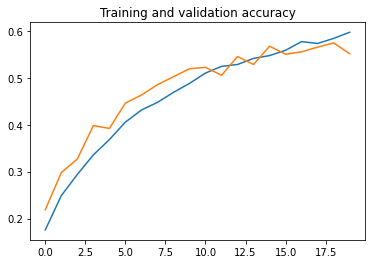

In [29]:
plotLearningCurves(historyX)

Answer: 5 	Guess: 5


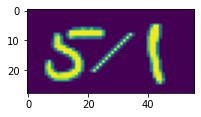

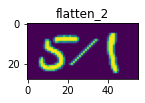

In [30]:
#@title Show layer output from MODELX ...

# Take random image from the training set.
take1_ds = test_ds.shuffle(10001).take(1)
for img, ans in take1_ds:
    img = img.numpy()
    ans = ans.numpy()
img = img.reshape((1,) + img.shape)    # np shape (1, 28, 28, 1)
gue = modelX.predict(img)
print("Answer:",ans, "\tGuess:",np.argmax(gue))
plt.figure(figsize=(3,3))
plt.imshow(img[0,:,:,0])                 # np shape (28, 28)

layer_output_maps = output_modelX.predict( img )
layer_names = [layer.name for layer in modelX.layers[1:]]
for layer_name, layer_map in zip(layer_names, layer_output_maps):
    if "flatten" in layer_name: 
        layer_map = layer_map.reshape(1,image_size[0],image_size[1])
        n_maps = layer_map.shape[0]  # 1 = number of maps

        # Map has shape (1, rows, columns)
        #rows = layer_map.shape[1]
        #cols = layer_map.shape[2]
        #image_grid = np.zeros((rows, cols))
        
        #for i in range(n_maps):
        x = layer_map[0, :, :]
        #x *= 255.0
        #image_grid[:, cols : 2 * cols] = x
            
        scale = 2.           
        plt.figure(figsize=(scale * n_maps, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(x)  #(image_grid, cmap='viridis')

In [31]:
layer_output_maps = output_modelX.predict( img )
layer_names = [layer.name for layer in modelX.layers[1:]]
for layer_name, layer_map in zip(layer_names, layer_output_maps):
    if "flatten" in layer_name:#len(layer_map.shape) == 4:# and not 'max_pooling' in layer_name:
         layer_map = layer_map.reshape(1,28,56)
    print (layer_name, layer_map.shape)

flatten_2 (1, 28, 56)
dense_3 (1, 100)
dropout_1 (1, 100)
dense_4 (1, 100)
dropout_2 (1, 100)
dense_5 (1, 100)


In [32]:
####################### Layer-outputs model
#layer_outputsX = [layer.output for layer in modelX.layers[1:]]
#output_modelX = Model(input_layer, layer_outputsX)
modelX_neurons = output_modelX.variables[0].numpy().T
modelX_neurons_df = pd.DataFrame(modelX_neurons)
neuronX_df = pd.DataFrame(modelX_neurons[2].reshape((28,56)))
#neuronX_df              

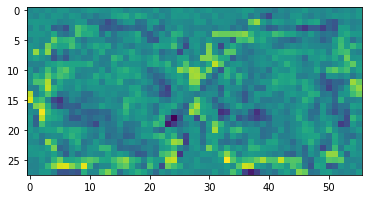

In [33]:
plt.imshow(neuronX_df)

-0.5619075298309326 0.5777977108955383 0.010709640569984913 0.14029666781425476
nxmin*255, nxmax*255 -143.28642010688782 147.33841627836227


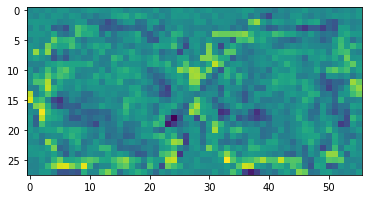

In [34]:
    #  x -= x.mean()
    #  x /= x.std()
    #  x *= 64
    #  x += 128
    #  x = np.clip(x, 0, 255).astype('uint8')
    #  x /= 255
    
nxmin = min(neuronX_df.min())
nxmax = max(neuronX_df.max())
nxmean = np.mean(neuronX_df.mean())
nxstd = np.mean(neuronX_df.std())
print (nxmin,nxmax,nxmean,nxstd)
print ("nxmin*255, nxmax*255", nxmin*255, nxmax*255)

#neuronX_df *= 255.
neuronX_df += nxstd
neuronX_df.clip(0,nxmax)
#neuronX_df *= 255

plt.imshow(neuronX_df)

In [35]:
modelX.variables[0].shape

TensorShape([1568, 100])

In [36]:
variablesX = modelX.variables[0].numpy()
(vmin,vmax,vmean,vstd) = (variablesX.min(), variablesX.max(), variablesX.mean(), variablesX.std())
(vmin,vmax,vmean,vstd)

(-1.1150836, 0.95745504, -0.0077219345, 0.11424848)

In [37]:
variablesX = np.clip((variablesX + abs(vstd))*255,0,255)
variablesX

array([[31.196608, 26.109781, 20.658371, ..., 30.578993, 44.401836,
        39.386177],
       [36.74255 , 35.125443, 30.107647, ..., 35.942978, 22.776588,
        28.925625],
       [32.66994 , 35.0452  , 22.840313, ..., 28.922493, 14.151342,
        24.663885],
       ...,
       [31.882315, 33.805916, 23.983334, ..., 31.067335, 22.400288,
        25.772448],
       [28.835207, 37.057087, 16.326778, ..., 43.123825, 15.73274 ,
        22.045433],
       [26.20892 , 19.830061, 41.670456, ..., 35.370197, 23.988224,
        15.542581]], dtype=float32)

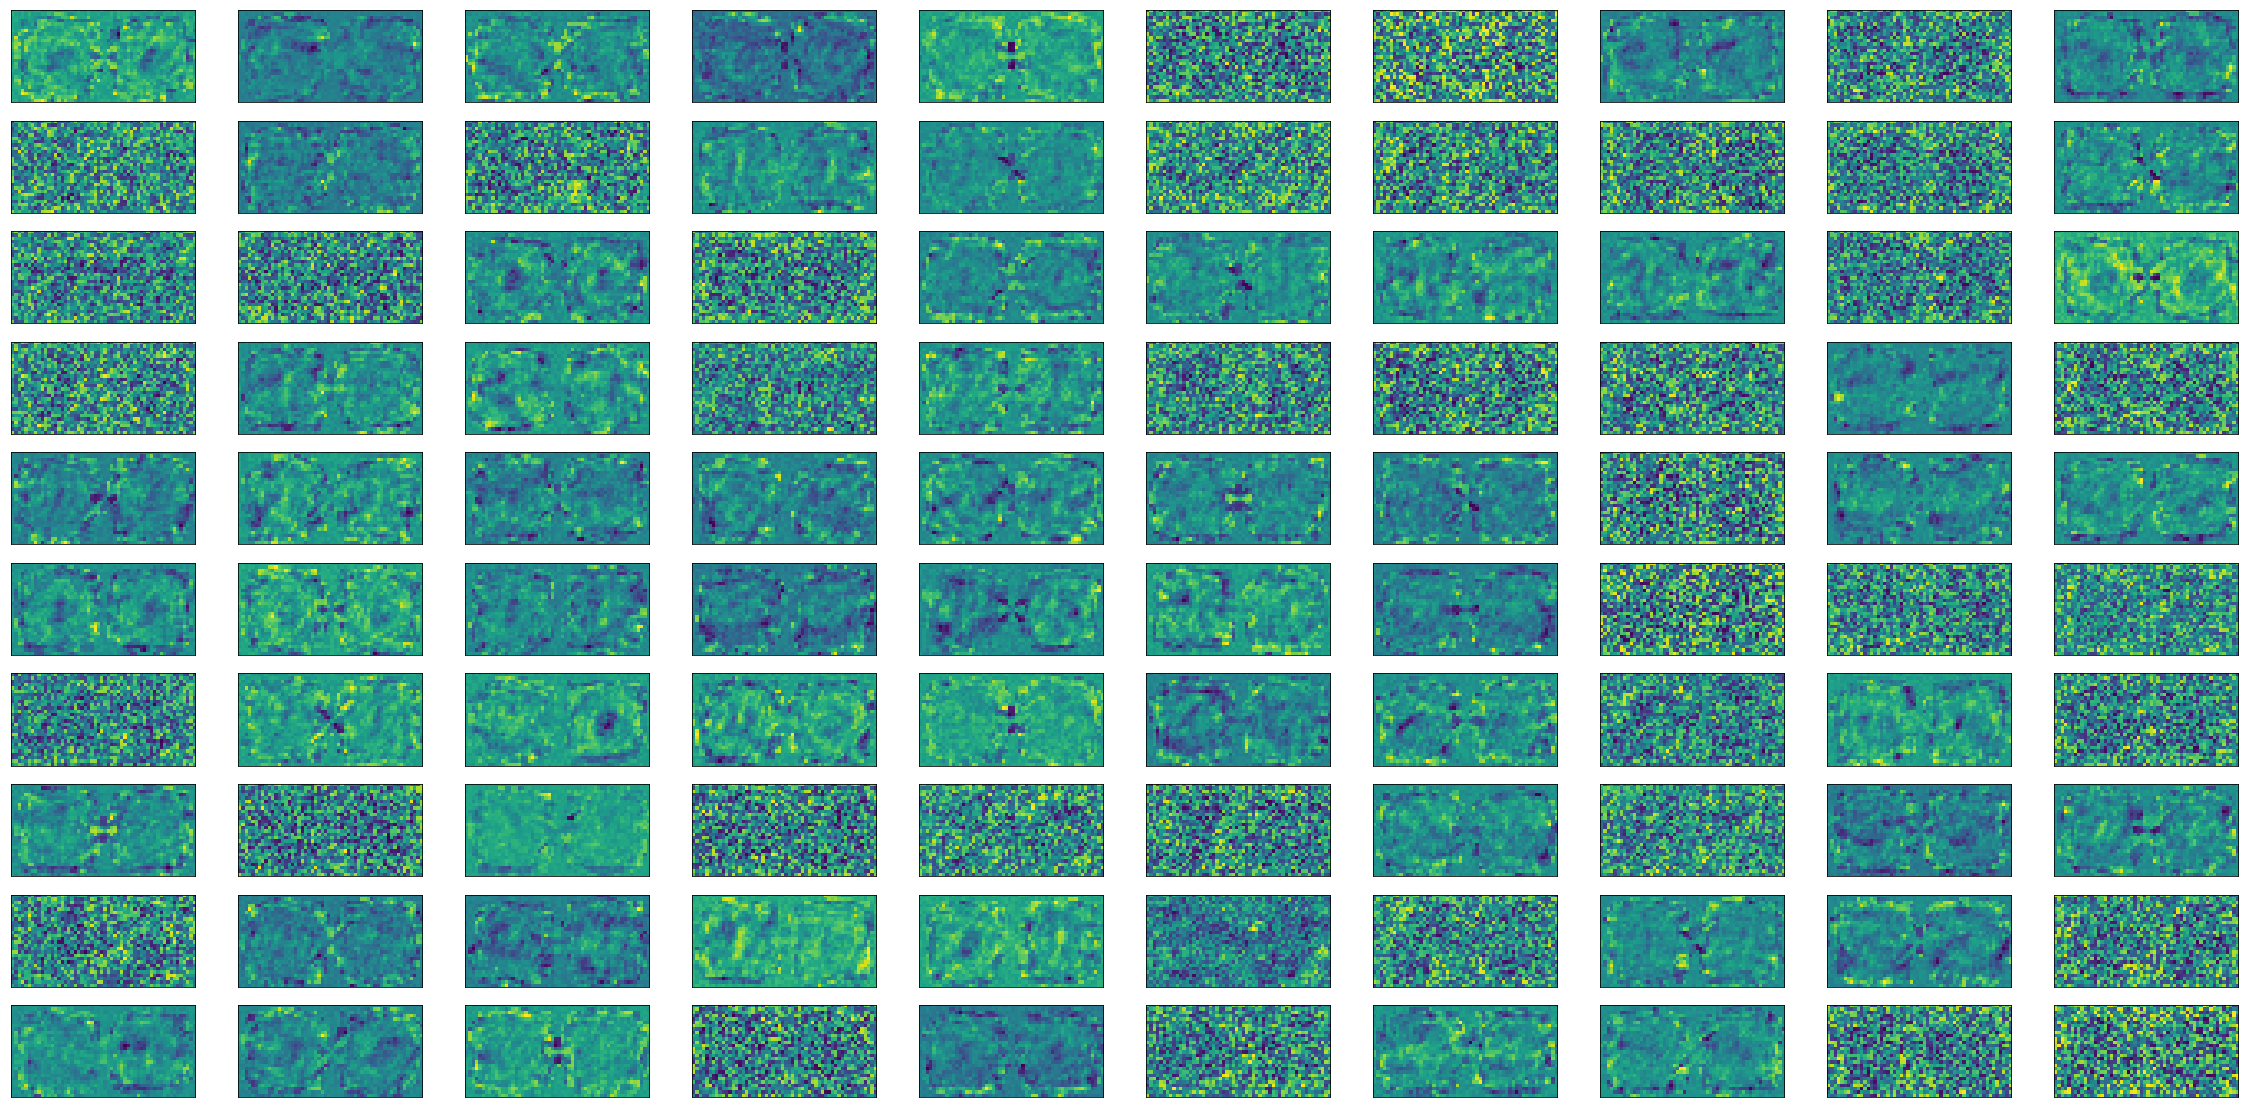

In [38]:
variables = modelX.variables[0].numpy()
num_nodes = variables.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(40, 2 * num_rows))
for coef, ax in zip(variables.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    coef = coef
    ax.matshow(coef.reshape(image_size), cmap=plt.cm.viridis)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

In [39]:
resultsX = get_results(100, modelX)
resultsX

Answer 6 	Guess 3 	p(A) 0.03 	p(G) 0.31
Answer 3 	Guess 3 	p(A) 0.78 	p(G) 0.78
Answer 10 	Guess 10 	p(A) 0.37 	p(G) 0.37
Answer 1 	Guess 1 	p(A) 0.84 	p(G) 0.84
Answer 3 	Guess 3 	p(A) 0.5 	p(G) 0.5
Answer 3 	Guess 3 	p(A) 0.81 	p(G) 0.81
Answer 2 	Guess 2 	p(A) 0.55 	p(G) 0.55
Answer 2 	Guess 2 	p(A) 0.35 	p(G) 0.35
Answer 1 	Guess 1 	p(A) 0.92 	p(G) 0.92


,Answer,Guess,P(A),P(G)
0,1,1,0.537388,0.537388
1,1,1,0.989107,0.989107
2,0,0,0.963334,0.963334
3,6,6,0.374142,0.374142
4,15,11,0.266355,0.355824
...,...,...,...,...
95,3,3,0.495188,0.495188
96,3,3,0.813874,0.813874
97,2,2,0.552438,0.552438
98,2,2,0.353088,0.353088


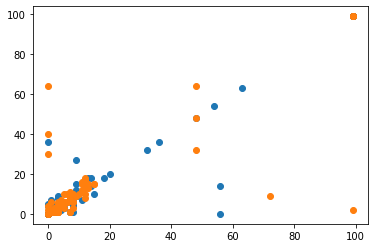

In [40]:
plt.scatter(results['Guess'],results['Answer'])
plt.scatter(resultsX['Guess'],resultsX['Answer'])

In [41]:
tvX = resultsX['Guess'] == resultsX['Answer']
wrongsX = resultsX.loc[~tvX]
#wrongsX.shape#, 
wrongsX.sort_values('Answer')

,Answer,Guess,P(A),P(G)
74,1,7,0.158007,0.234537
36,1,2,0.166344,0.210466
44,1,2,0.330337,0.419406
33,1,2,0.366428,0.557230
51,1,3,0.212976,0.499221
52,1,2,0.388002,0.471473
20,1,2,0.265055,0.582927
53,1,3,0.102571,0.553796
7,1,7,0.027358,0.713603
75,1,3,0.140383,0.372025


Label: 20 	Predict: 40
pLabel = 0.21080138 	pPredict =  0.39941126


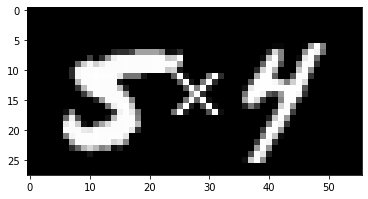

In [42]:
# "one shot iterator"

answers, guesses, pA, pG, img = guessing(1, model=modelX, return_image=True)
print ("Label:", answers[0], "\tPredict:", guesses[0])
print ("pLabel =",pA[0], "\tpPredict = ", pG[0])
plt.imshow(img[0,:,:,0],cmap="gray")

In [43]:
def showWeights():
    weights0 = modelX.weights[0].numpy()
    num_nodes = weights0.shape[1]
    num_rows = int(math.ceil(num_nodes / 10.0))
    fig, axes = plt.subplots(num_rows, 10, figsize=(40, 2 * num_rows))
    for coef, ax in zip(weights0.T, axes.ravel()):
        # Weights in coef is reshaped from 1x784 to 28x28.
        ax.matshow(coef.reshape(image_size), cmap=plt.cm.bone)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

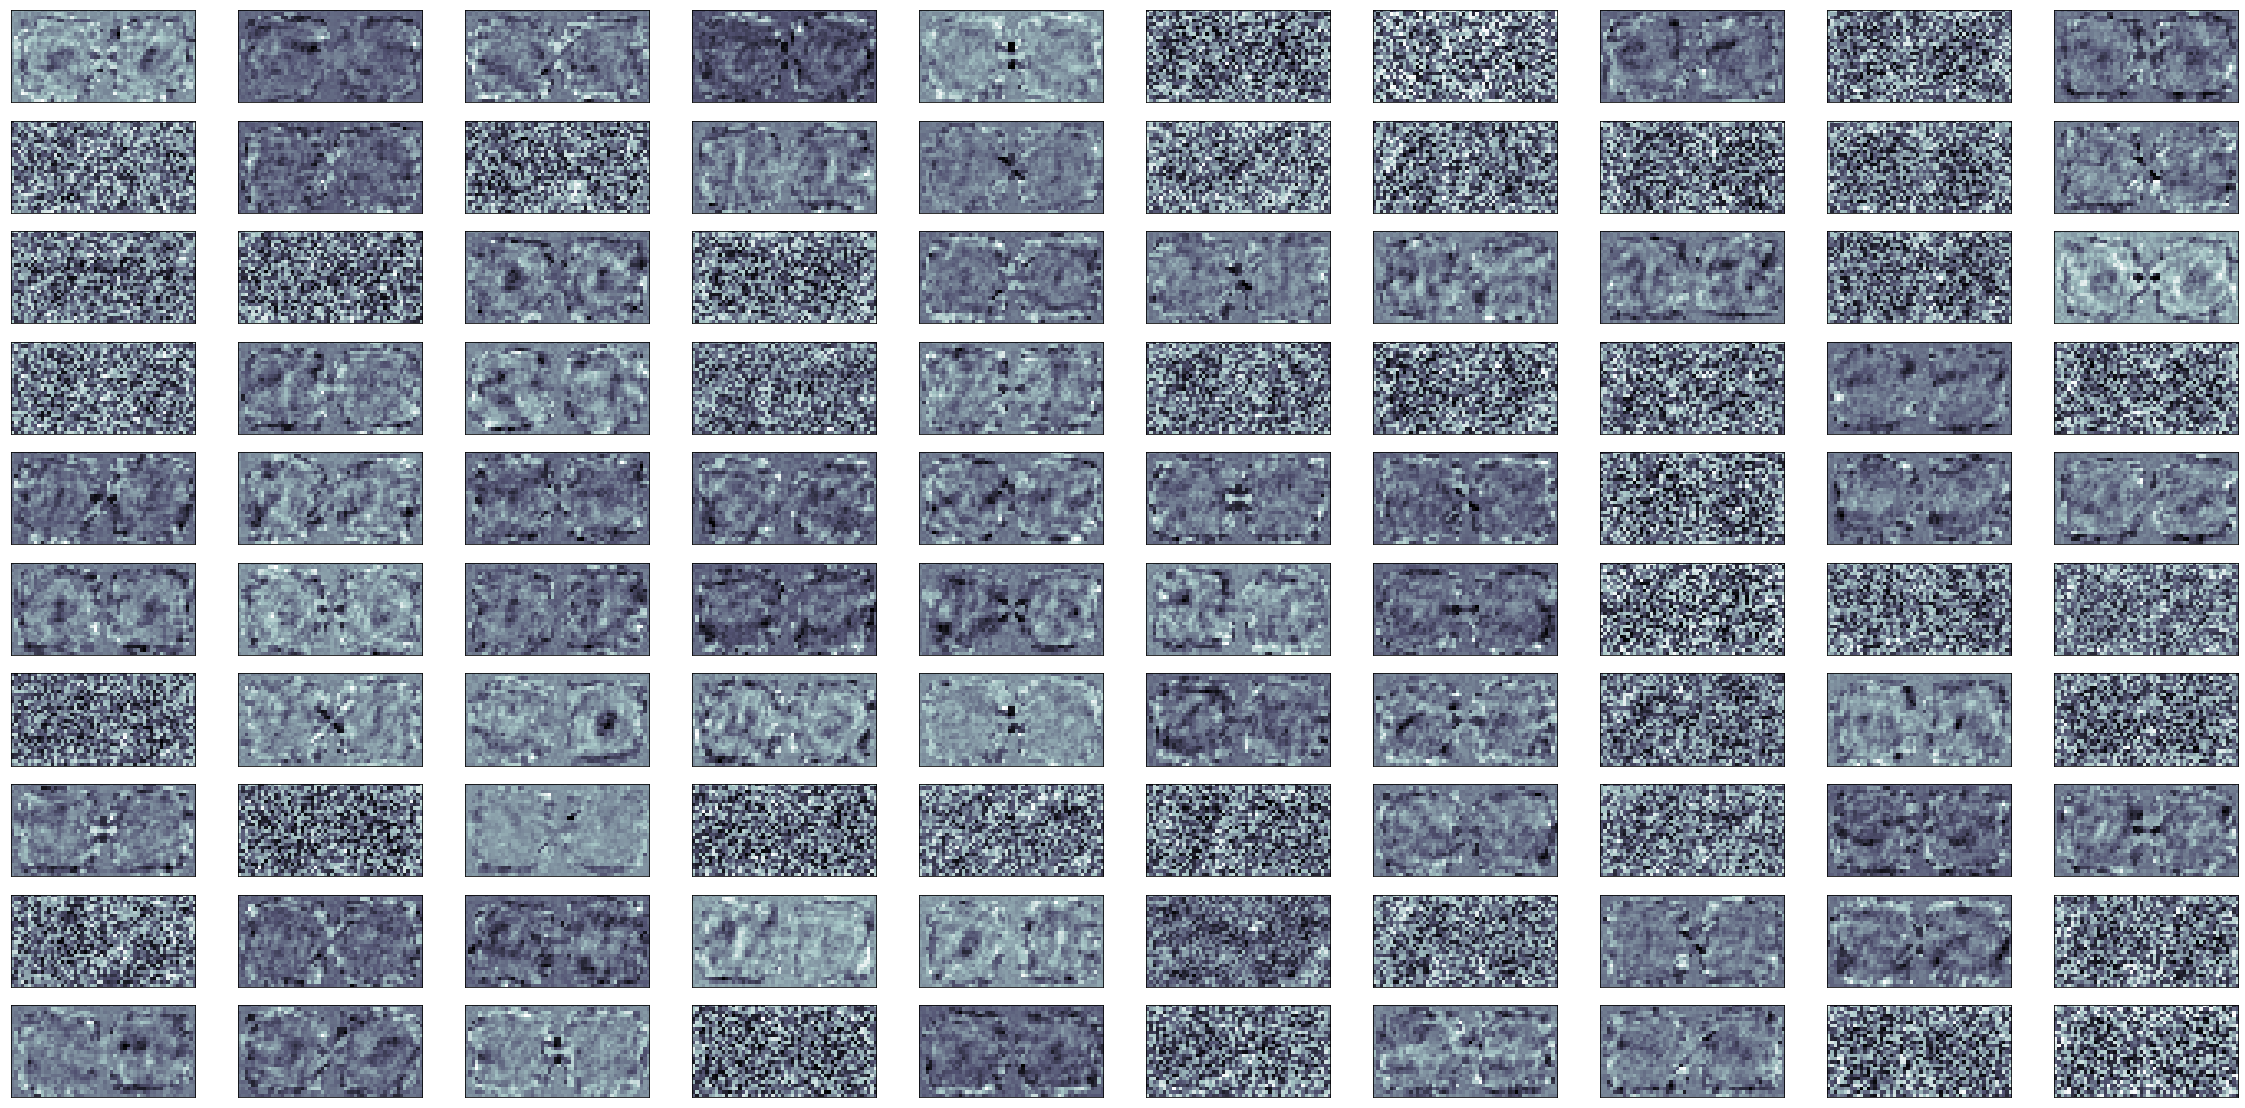

In [44]:
showWeights()

In [45]:
#dense0 = pd.DataFrame(modelX.variables[0].numpy().T)
#d0_neurons = np.zeros((100,28,56))
#for i in range(dense0.shape[0]):
#    d0_neurons[i] = np.reshape(list(dense0.iloc[i]),image_size)
#plt.imshow(d0_neurons[7])